# Quick tour of OpenVisus in python

To begin using OpenVisus install it

```
python -m pip install --no-cache-dir --upgrade --force-reinstall OpenVisus
python -m OpenVisus configure 
```


First import OpenVisus

In [1]:
import sys
sys.path.append("./build/RelWithDebInfo")
from OpenVisus import *

PythonEngine is working fine


create an empty RGB dataset

In [2]:
PyDataset.Create(url="tmp/empty3d.idx",dims=[1025,512,256],fields=[Field("data","uint8[3]","row_major")])

create a 2d dataset from numpy array

In [3]:
from PIL import Image
data=numpy.asarray(Image.open('datasets/cat/rgb.png'))
PyDataset.Create(url="tmp/visus2d.idx", dim=2,data=data)

(256, 256, 3) [256, 256] 0 256 0 256


create a 3d dataset from numpy array

In [4]:
data=numpy.zeros((100,100,100,3),dtype=numpy.float32) 
PyDataset.Create(url="tmp/visus3d.idx", dim=3, data=data)

(100, 100, 100, 3) [100, 100, 100] 0 100 0 100 0 100


create a 3d datasets from 2d slices

In [5]:
from urllib.request import urlopen

data=numpy.asarray(Image.open(urlopen('https://raw.githubusercontent.com/sci-visus/OpenVisus/master/datasets/cat/rgb.png')))
height,width=data.shape[0],data.shape[1]

# replicate one 2d images 10 times
depth=10

def generateSlices():
    for I in range(depth): 
        yield data

db=PyDataset.Create(url="tmp/visus3d_slices.idx",dims=[width,height,depth],fields=[Field("data","uint8[3]","row_major")])
db.writeSlabs(generateSlices())

(10, 256, 256, 3) [256, 256, 10] 0 256 0 256 0 10


read a single slice

In [6]:
data=next(db.read(z=[0,1]))[0,:,:]


import matplotlib.pyplot as plt

def ShowImage(data,width=10):
    ratio=float(data.shape[1])/data.shape[0]
    fig = plt.figure(figsize = (width,width*ratio))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(data, origin='lower')
    plt.show()

ShowImage(data)

<Figure size 1000x1000 with 1 Axes>

read stuff in one shot at full resolution

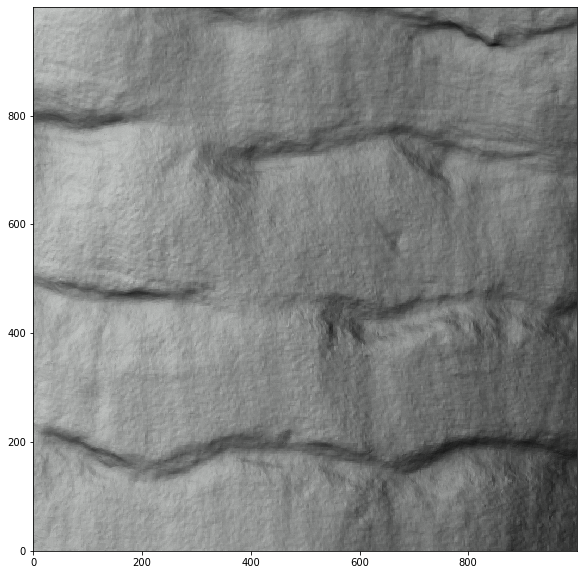

In [7]:
db=PyDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=david_subsampled")
data=next(db.read(x=[10000,11000],y=[10000,11000]))

ShowImage(data)


show image coarse to fine

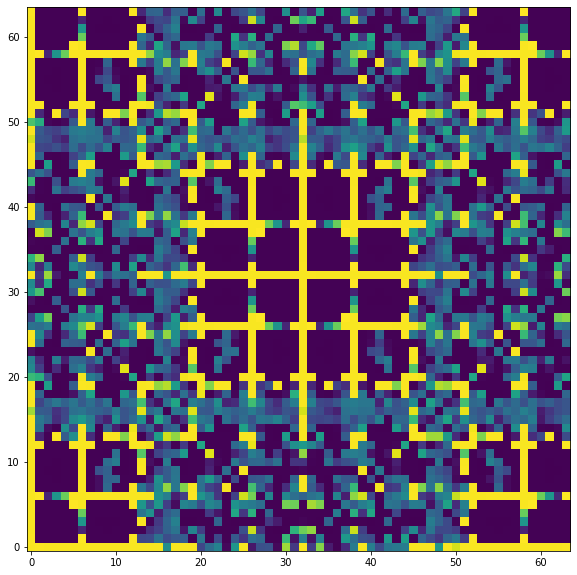

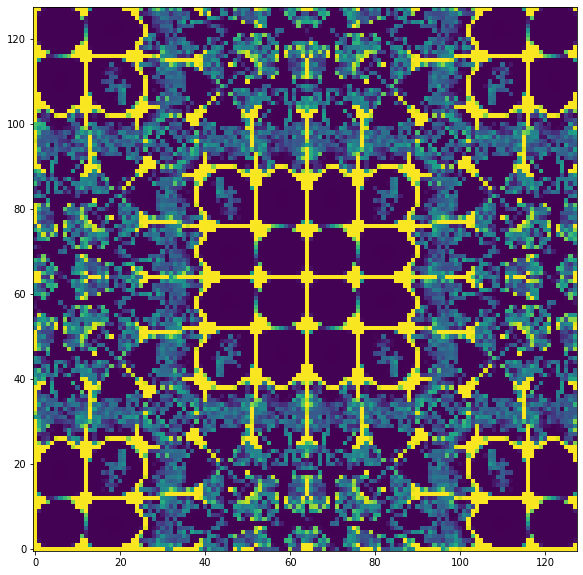

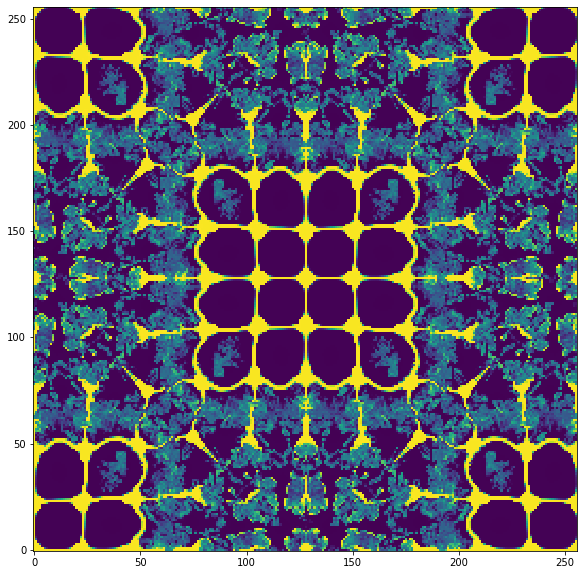

In [8]:
db=PyDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1")
for data in db.read(x=[0,2048],y=[0,2048],z=[1024,1025], num_refinements=3, quality=-9):
    ShowImage(data[0,:,:])

get data in normalized coordinates

(440, 183, 3) uint8


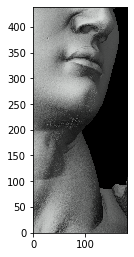

In [9]:
db=PyDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=david_subsampled")
data=next(db.read(x=[0.35,0.45],y=[0.8,0.9],quality=-8))
print(data.shape,data.dtype)
ShowImage(data)

Start a local visus server for one dataset

In [13]:
modvisus = ModVisus()

port=10000
idx="./datasets/cat/rgb.idx"
config="""
<visus>
  <datasets>
    <dataset name='default' url='{}' permissions='public' />
  </datasets>
</visus>
""".format(idx)
modvisus.configureDatasets(ConfigFile.fromString(config))
server=NetServer(port, modvisus)

server.runInBackground()

body=urlopen('http://127.0.0.1:{}/mod_visus?action=read_dataset&dataset=default'.format(port)).read().decode("utf8")
print(body)

server.signalExit()
server.waitForExit()
print("server done")

(version)
6
(box)
0 255 0 255
(fields)
data uint8[3] format(0) default_value(0) min(0 0 0) max(0 0 0) 
(bits)
V0101010101010101
(bitsperblock)
16
(blocksperfile)
1
(interleave block)
0
(filename_template)
./rgb/%01x.bin

server done
